# Using CellTypist for multi-label classification
This notebook showcases the multi-label classification for scRNA-seq query data using either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## About multi-label cell type classification

An ideal CellTypist model is supposed to be trained from a reference atlas with a comprehensive cell type repertoire. For the built-in models, we have collected a large number of cell types; yet, the presence of unexpected (e.g., low-quality or novel cell types) and ambiguous cell states (e.g., doublets) in the query data is beyond the prediction that CellTypist can achieve with a 'find-a-best-match' mode. To overcome this, CellTypist provides the option of multi-label cell type classification, which assigns 0 (i.e., unassigned), 1, or >=2 cell type labels to each query cell.

## Install CellTypist

In [1]:
!pip install celltypist

  Using cached celltypist-0.2.1-py3-none-any.whl (5.3 MB)


In [2]:
import scanpy as sc
import pandas as pd

In [3]:
import celltypist
from celltypist import models

## Download a scRNA-seq dataset of 500 immune cells

In [4]:
adata_500 = sc.read('celltypist_demo_folder/demo_500_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_500_cells.h5ad')

  0%|          | 0.00/9.41M [00:00<?, ?B/s]

This dataset includes 500 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [5]:
adata_500.shape

(500, 18950)

The expression matrix (`adata_500.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [6]:
adata_500.X.expm1().sum(axis = 1)[:10]

matrix([[10000.   ],
        [10000.001],
        [ 9999.999],
        [10000.001],
        [10000.003],
        [ 9999.999],
        [10000.   ],
        [10000.002],
        [10000.   ],
        [ 9999.999]], dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [7]:
adata_500.obs

,cell_type
cell1,Plasma cells
cell2,Plasma cells
cell3,Plasma cells
cell4,Plasma cells
cell5,Plasma cells
...,...
cell496,Macro_pDC
cell497,Macro_pDC
cell498,Macro_pDC
cell499,Macro_pDC


Among the 12 cell types in this data, 10 are shared with the CellTypist built-in models. For the remaining two, `Microglia` is a novel cell type not covered by CellTypist (currently our models do not involve the brain), and `Macro_pDC` is a cell type *in silico* generated by blending the expression of macrophages with plasmacytoid dendritic cells.

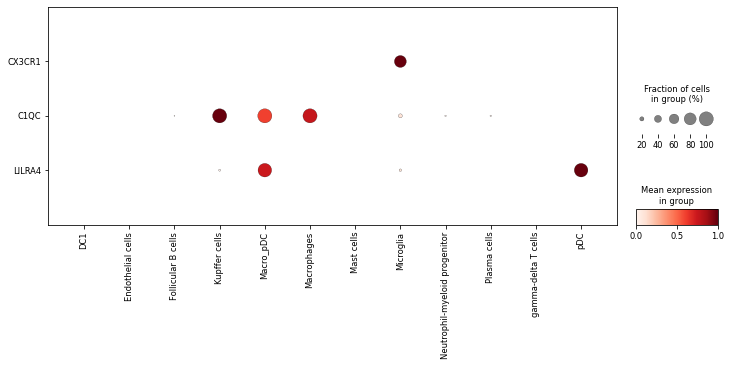

In [8]:
sc.pl.dotplot(adata_500, ['CX3CR1', 'C1QC', 'LILRA4'], groupby = 'cell_type', swap_axes = True, standard_scale = 'var', figsize = [12, 4])

## Inspect the CellTypist built-in models

Download the latest CellTypist models.

In [9]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/jovyan/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


All models are stored in `models.models_path`.

In [10]:
models.models_path

'/home/jovyan/.celltypist/data/models'

Get an overview of the models and what they represent.

In [11]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Immune_All_PIP.pkl,immune cell types combined from 16 adult human...
3,Immune_All_AddPIP.pkl,immune cell types combined from >20 human tiss...
4,COVID19_Immune_Landscape.pkl,immune subtypes from lung and blood of COVID-1...
5,Cells_Fetal_Lung.pkl,cell types from human embryonic and fetal lungs
6,Cells_Intestinal_Tract.pkl,"intestinal cells from fetal, pediatric and adu..."
7,Cells_Lung_Airway.pkl,cell populations from scRNA-seq of five locati...
8,Developing_Mouse_Brain.pkl,cell types from the embryonic mouse brain betw...
9,Healthy_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from h...


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

In [12]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')

Show the model meta information.

In [13]:
model

CellTypist model with 90 cell types and 5212 features
    date: 2022-04-04 23:51:15.159293
    details: immune sub-populations combined from 20 tissues of 19 studies
    source: https://doi.org/10.1101/2021.04.28.441762
    version: v2
    cell types: B cells, CD16+ NK cells, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

This model contains 90 cell states.

In [14]:
model.cell_types

array(['B cells', 'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a',
       'CD8a/b(entry)', 'CMP', 'Classical monocytes', 'Cycling B cells',
       'Cycling DCs', 'Cycling NK cells', 'Cycling T cells',
       'Cycling gamma-delta T cells', 'Cycling monocytes', 'DC',
       'DC precursor', 'DC1', 'DC2', 'DC3', 'Double-negative thymocytes',
       'Double-positive thymocytes', 'ELP', 'ETP', 'Early MK',
       'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Fibroblasts', 'Follicular B cells', 'Follicular helper T cells',
       'GMP', 'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cells', 'Late erythroid', 'MAIT cells', 'MEMP', 'MNP',
       'Macrophages', 'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocyte-erythroid-mast cell progenitor',
       'Megakaryocy

## Single-label classification by finding the best match in the model
In this section, we show the procedure of finding the most likely cell type labels from built-in models for the query dataset.

We use the default mode (`mode = 'best match'`) in [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.html#module-celltypist.annotate) to transfer cell type labels from the model to the query dataset. With this mode on, each query cell is predicted into the cell type with the largest score/probability among all possible cell types in the model.

In [15]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_500, model = model, majority_voting = True, mode = 'best match')
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_500, model = 'Immune_All_Low.pkl', majority_voting = True, mode = 'best match')

🔬 Input data has 500 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 4715 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [16]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
cell1,Plasma cells,8,Follicular B cells
cell2,Plasma cells,6,Plasma cells
cell3,Plasma cells,7,Plasma cells
cell4,Plasma cells,6,Plasma cells
cell5,Plasma cells,6,Plasma cells
...,...,...,...
cell496,pDC,10,Macrophages
cell497,Macrophages,17,pDC
cell498,Macrophages,10,Macrophages
cell499,Macrophages,10,Macrophages


Transform the prediction result into an `AnnData`.

In [17]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata_500`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.classifier.AnnotationResult.to_adata).

In [18]:
adata.obs

,cell_type,predicted_labels,over_clustering,majority_voting,conf_score
cell1,Plasma cells,Plasma cells,8,Follicular B cells,0.996313
cell2,Plasma cells,Plasma cells,6,Plasma cells,0.999478
cell3,Plasma cells,Plasma cells,7,Plasma cells,0.999957
cell4,Plasma cells,Plasma cells,6,Plasma cells,0.996070
cell5,Plasma cells,Plasma cells,6,Plasma cells,0.998888
...,...,...,...,...,...
cell496,Macro_pDC,pDC,10,Macrophages,0.187152
cell497,Macro_pDC,Macrophages,17,pDC,0.849831
cell498,Macro_pDC,Macrophages,10,Macrophages,0.809677
cell499,Macro_pDC,Macrophages,10,Macrophages,0.937306


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata` 
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [19]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)

Visualise the prediction results.

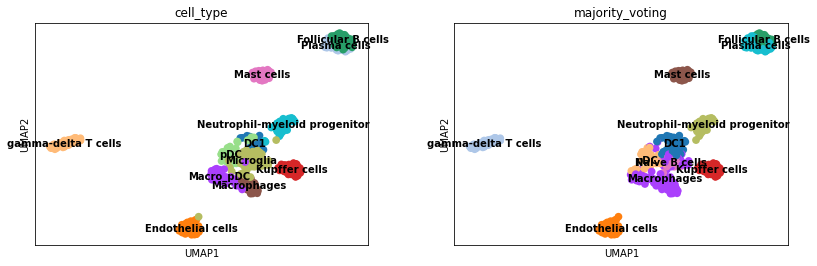

In [20]:
sc.pl.umap(adata, color = ['cell_type', 'majority_voting'], legend_loc = 'on data')

As the images show, with the default mode, `Microglia` is predicted as a mixture of cell types, and `Macro_pDC` is mostly predicted as `Macrophages`.

In [21]:
pd.crosstab(adata.obs.cell_type, adata.obs.majority_voting).loc[['Microglia','Macro_pDC']]

majority_voting,DC1,Endothelial cells,Follicular B cells,Kupffer cells,Macrophages,Mast cells,Naive B cells,Neutrophil-myeloid progenitor,Plasma cells,gamma-delta T cells,pDC
cell_type,,,,,,,,,,,
Microglia,13,1,0,0,22,0,18,1,0,0,5
Macro_pDC,0,0,0,0,30,0,0,0,0,0,10


Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.html#module-celltypist.plot), which quantitatively compares the CellTypist prediction result (e.g. `predicted_labels` here) with the cell types pre-defined in the `AnnData` (here `cell_type`).

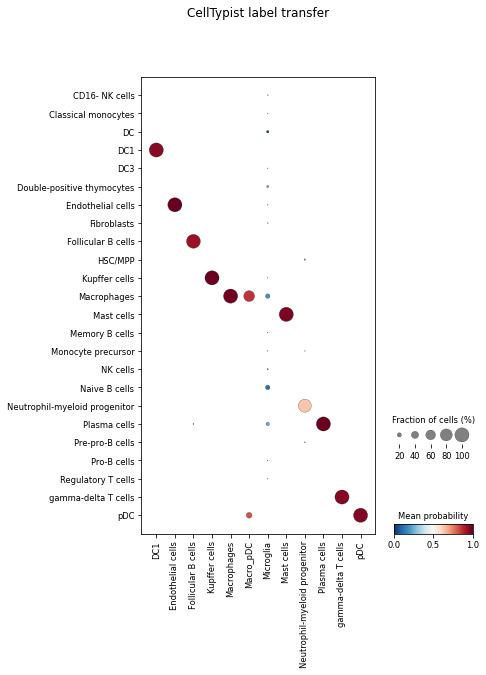

In [22]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'predicted_labels')

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows). You can also change the value of `use_as_prediction` to `majority_voting` to compare the majority-voting result with the pre-defined cell types.

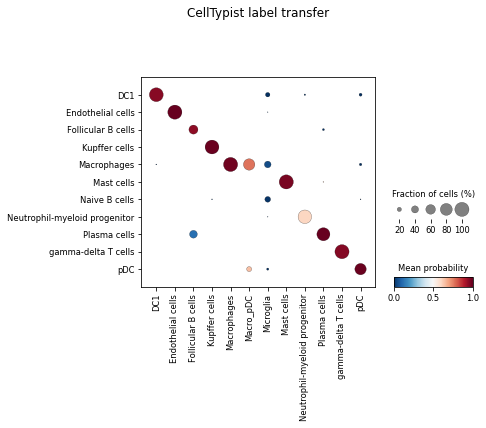

In [23]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

## Multi-label classification by utilising a probability threshold
In this section, we show the procedure of transferring multiple cell type labels from built-in models to the query dataset.

All cell types from the CellTypist models are trained in an one-vs-rest fashion, resulting in independent probability estimates that can be compared across cell types. Probabilities are transformed from the decision scores by the sigmoid function, and are kept as is without summing up to one for each query cell. Through this, a probability threshold (default to 0.5, `p_thres = 0.5`) can be used to determine the cell type(s) assigned to a given cell.

Turn on the multi-label classification by setting the `mode = 'prob match'` argument.

In [24]:
# `p_thres` defaults to 0.5.
predictions = celltypist.annotate(adata_500, model = 'Immune_All_Low.pkl', majority_voting = True, mode = 'prob match', p_thres = 0.5)

🔬 Input data has 500 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 4715 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [25]:
adata = predictions.to_adata()

In [26]:
sc.tl.umap(adata)

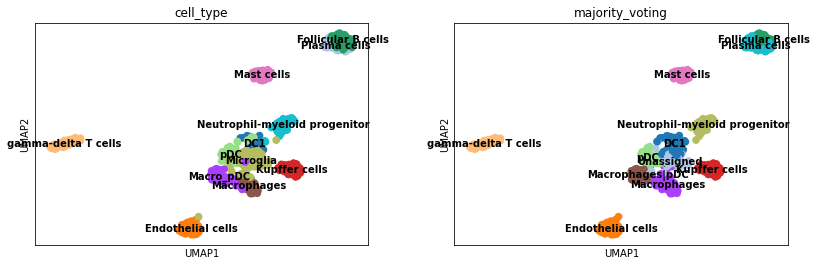

In [27]:
sc.pl.umap(adata, color = ['cell_type', 'majority_voting'], legend_loc = 'on data')

With the mode of probabilistic match, `Microglia` is predicted as `Unassigned`, and `Macro_pDC` is predicted as `Macrophages|pDC` (which follows the naming scheme of `celltype1|celltyp2`)

The probability estimates can be inserted into the adata as well by setting `insert_prob = True` in the `to_adata` function. After the insertion, multiple columns will show up in the cell metadata, with each column's name being a cell type name (no `prefix` by default) representing probabilities of this cell type distributed across the query cells.

In [28]:
adata = predictions.to_adata(insert_prob = True)
adata.obs[['cell_type', 'Plasma cells']]

,cell_type,Plasma cells
cell1,Plasma cells,9.963127e-01
cell2,Plasma cells,9.994784e-01
cell3,Plasma cells,9.999570e-01
cell4,Plasma cells,9.960702e-01
cell5,Plasma cells,9.988881e-01
...,...,...
cell496,Macro_pDC,4.877905e-06
cell497,Macro_pDC,5.033182e-07
cell498,Macro_pDC,3.668227e-06
cell499,Macro_pDC,5.105727e-06


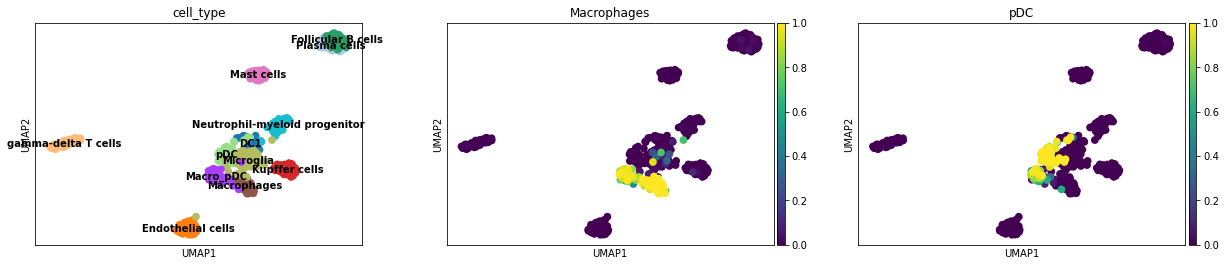

In [29]:
sc.pl.umap(adata, color = ['cell_type', 'Macrophages', 'pDC'], vmin = 0, vmax = 1, legend_loc = 'on data')

Examination of probability distributions of `Macrophages` and `pDC` shows the co-existence of their signatures in the doublet cluster `Macro_pDC`, as well as noticeable `Macrophages` scores in the `Microglia` cluster. Thus even CellTypist assigns the `Microglia` as `Unassigned`, the probability scores still indicate their possible transcriptomic similarity with `Macrophages`.

## Multi-label classification using a custom model
In this section, we show the procedure of generating a custom model and transferring multiple labels from the model to the query data.

Download a dataset of 2,000 immune cells as the training set.

In [30]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

  0%|          | 0.00/34.1M [00:00<?, ?B/s]

Use previously downloaded scRNA-seq dataset of 500 immune cells as a query.

In [31]:
adata_500 = sc.read('celltypist_demo_folder/demo_500_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_500_cells.h5ad')

Derive a custom model by training the data using the [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.html#) function.

In [32]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_2000, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
✂️ 2749 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2645 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


Refer to the function [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.html#) for what each parameter means, and to the [usage](https://github.com/Teichlab/celltypist#usage) for details of model training.

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [33]:
# Save the model.
new_model.write('celltypist_demo_folder/model_from_immune2000.pkl')

You can load this model by `models.Model.load`.

In [34]:
new_model = models.Model.load('celltypist_demo_folder/model_from_immune2000.pkl')

Next, we use this model to predict the query dataset of 500 immune cells.

In [35]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_500, model = new_model, majority_voting = True, mode = 'prob match', p_thres = 0.5)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_500, model = 'celltypist_demo_folder/model_from_immune2000.pkl', majority_voting = True, mode = 'prob match', p_thres = 0.5)

🔬 Input data has 500 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 2645 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [36]:
adata = predictions.to_adata(insert_prob = True)

In [37]:
sc.tl.umap(adata)

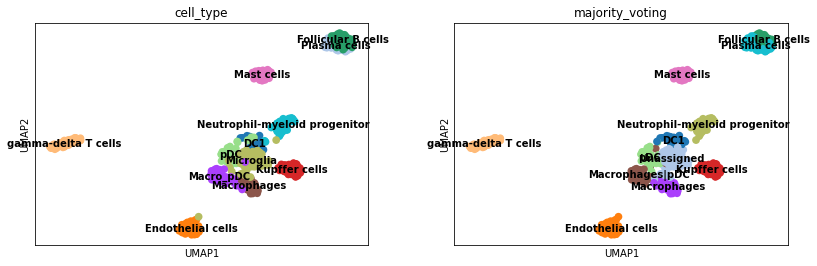

In [38]:
sc.pl.umap(adata, color = ['cell_type', 'majority_voting'], legend_loc = 'on data')

Again, `Microglia` is predicted as `Unassigned`, and `Macro_pDC` is predicted as `Macrophages|pDC`.

<AxesSubplot:title={'center':'Macro_pDC'}>

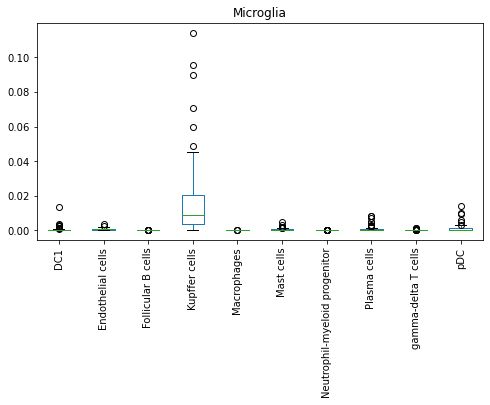

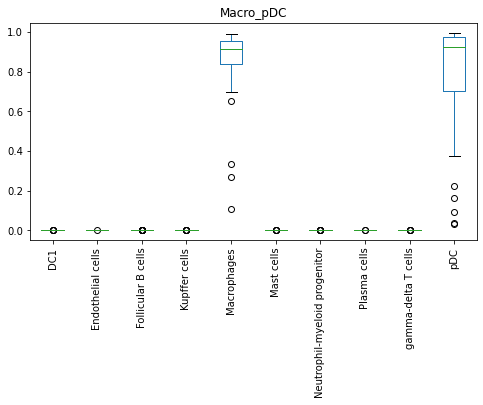

In [39]:
adata.obs.loc[adata.obs.cell_type == 'Microglia', new_model.cell_types].plot(kind = 'box', rot = 90, figsize = [8, 4], title = 'Microglia')
adata.obs.loc[adata.obs.cell_type == 'Macro_pDC', new_model.cell_types].plot(kind = 'box', rot = 90, figsize = [8, 4], title = 'Macro_pDC')

Based on this model, `Microglia`, though designated as `Unassigned` by CellTypist, holds relatively higher probability scores with `Kupffer cells`, signifying a possible tissue-resident macrophage type. `Macro_pDC`, on the other hand, holds relatively higher probability scores with both `Macrophages` and `pDC`.

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [40]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [41]:
model.cell_types

array(['DC1', 'Endothelial cells', 'Follicular B cells', 'Kupffer cells',
       'Macrophages', 'Mast cells', 'Neutrophil-myeloid progenitor',
       'Plasma cells', 'gamma-delta T cells', 'pDC'], dtype=object)

Extract the top three driving genes of `Macrophages` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.html#celltypist.models.Model.extract_top_markers) method.

In [42]:
top_3_genes = model.extract_top_markers("Macrophages", 3)
top_3_genes

array(['EREG', 'AQP9', 'OLR1'], dtype=object)

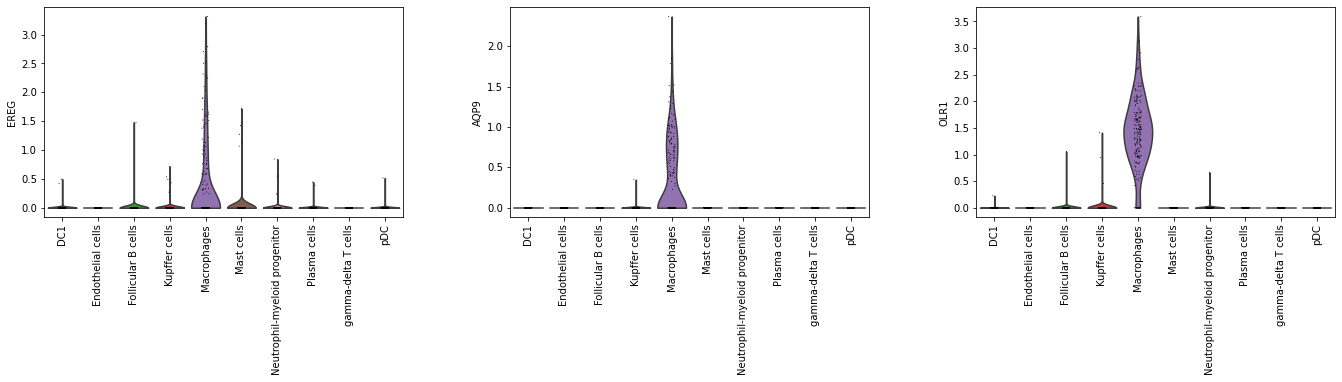

In [43]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

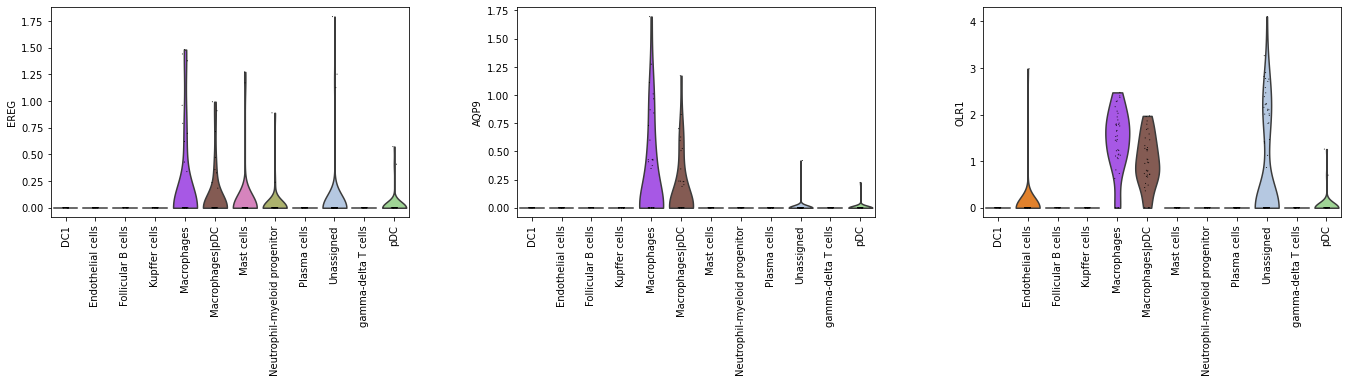

In [44]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_500, top_3_genes, groupby = 'majority_voting', rotation = 90)